# Comparison between the network developed for AnDi2024 and the one of PHYSICAL REVIEW E 100, 010102(R) (2019)

In [1]:
import csv as csv
import numpy as np
import scipy 
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
# from fbm import FBM
from sklearn.metrics import mean_absolute_error
# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm, rc


import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import losses, metrics
from keras import backend as k

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.models import load_model
import datetime as dtim
from datetime import datetime
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
from keras.utils import plot_model


In [2]:
def nice_fig(xla, yla, xli, yli, size, fs=12): 
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)
    plt.figure(figsize=(size[0],size[1]))
    plt.xlabel(xla,fontsize=fs)
    plt.ylabel(yla,fontsize=fs)
    plt.xlim(xli)
    plt.ylim(yli)
    plt.tick_params(axis='both', which='major', labelsize=fs)


Below are some functions to compute the MSD and prepare the data so that the network from the PRE works

In [3]:
#FUNCTION TO TURN SPLIT DATA IN NORMALIZED SUB-TRAJECTORIES, choosing only data corresponding to a certain h
#USING TIMES TOO Otpion to normalize!!
#Should find a more elegant way of using the hmin and hmax, now i have to express it anyway
def data_split(data_tot,meas_times,labels,start_row,num_row,traj_len,n_in,n_samples,hmin=0.,hmax=1,limith=False,normalization=True,p_p=1):

    j=0



    tr=data_tot[start_row:num_row+start_row]
    sel_times=meas_times[start_row:num_row+start_row]
    tar=labels[start_row:num_row+start_row]

    if(limith==True):
        
        tr=tr[np.where((tar<=hmax) & (tar >=hmin))]
        sel_times=sel_times[np.where((tar<=hmax) & (tar >=hmin))]
        tar=tar[((tar<=hmax) & (tar >=hmin))]

    if(n_samples>1):
        
        gap=int((data_tot.shape[1]-n_in-traj_len)/(n_samples-1))
    else:
        gap=0    
    print("n initial=",n_in,"gap=",gap)
    if(gap<traj_len):
        print("warning!! Overlapping trajectories. gap=",gap,"trajectory length=",traj_len,"final_point=",(n_samples-1)*gap+n_in+traj_len,"data length",data_tot.shape[1])

    if(normalization==True):
        trj=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
        test_data_new=(trj-(np.tile(np.transpose([np.mean(trj,axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(trj,axis=1)]),(1,traj_len)))
        test_times=np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),axis=1)
#train_data_new=(data_tot[start_row:30000,:traj_len]-(np.tile(np.transpose([np.mean(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len)))
        test_labels_large=tar
#test_labels=labels[start_row:num_row+start_row]
        #print(test_data_new.shape)
        #print("trj=",trj.shape)
        #print("sart=",n_in+gap*j,"end=",n_in+gap*j+traj_len)
        for j in range(1,n_samples):
            trj=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
            #print("sart=",n_in+gap*j,"end=",n_in+gap*j+traj_len)
            #print(trj.shape)
            test_data_new=np.concatenate((test_data_new,(trj-(np.tile(np.transpose([np.mean(trj,axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(trj,axis=1)]),(1,traj_len)))),axis=0)
    #test_data_new=np.concatenate((test_data_new,(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]-np.mean(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]))/np.std(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len])),axis=0)
            test_labels_large=np.append(test_labels_large,tar)
            test_times=np.concatenate((test_times,np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),axis=1)),axis=0)
    #test_labels=np.append(test_labels,many_label2)  
    else:
        test_data_new=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
        test_times=np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),axis=1)
#train_data_new=(data_tot[start_row:30000,:traj_len]-(np.tile(np.transpose([np.mean(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len)))
        test_labels_large=tar
#test_labels=labels[start_row:num_row+start_row]
        for j in range(1,n_samples):
            test_data_new=np.concatenate((test_data_new,tr[:,n_in+gap*j:n_in+gap*j+traj_len]),axis=0)
    #test_data_new=np.concatenate((test_data_new,(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]-np.mean(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]))/np.std(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len])),axis=0)
            test_labels_large=np.append(test_labels_large,tar)
            test_times=np.concatenate((test_times,np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),axis=1)),axis=0)
    #test_labels=np.append(test_labels,many_label2) 
        


#normalization of time stamps, potentially dangerous!!!!!!!
    test_times=test_times*p_p/traj_len
    
#RESHAPING
    test_set=np.transpose(np.array((np.transpose(test_data_new),np.transpose(test_times))))  
    return test_set, test_labels_large, test_data_new,test_times
   

In [4]:
#Function to compute the mean square displacement of a trajectory "trace". Returns a vector with "max_len" entries corresponding to the MSD with delays of 1,2,... "max_len"
def msd_expf( trace, max_len ):
    dada=[]
    for i in range(1,max_len+1):
        dada.append(np.mean((trace[i:]-trace[:-i])**2))
   # A = np.vstack([np.log(np.arange(1,max_len)/1000), np.ones(len(msd_exp))]).T
   # H=(np.linalg.lstsq(A, np.log(msd_exp),rcond=None )[0])[0]/2  

    return  np.asarray(dada);    
    
   
    

#Function to compute the H exponent by a linear (Least Square) fit of the loglog plot. Maybe one should consider that longer delays have larger delays have larger uncertainties.
def h_exp (ff ,nmax ):
    

    A = np.vstack([np.log(np.arange(1,nmax+1)/1000), np.ones(len(msd_expf( ff,nmax )))]).T
    H=(np.linalg.lstsq(A, np.log(msd_expf( ff,nmax )),rcond=None )[0])[0]/2  

    return  H;



#Function to compute the H exponent by a weighted least square
#function to be fitted
def flin(x, a, b):
    
    return a*x+b

def h_w (ff ,nmax ,ww):
    
    if ww==0:
        popt, pcov = scipy.optimize.curve_fit(flin,np.log(np.arange(1,nmax+1)),np.log(msd_expf( ff,nmax )))
        
    else:
        lala=np.arange(1,nmax+1)
        ss=1/np.sqrt(len(ff)-lala)
        popt, pcov = scipy.optimize.curve_fit(flin,np.log(np.arange(1,nmax+1)),np.log(msd_expf( ff,nmax )),sigma=ss)
        
    
    
    

    return  popt[0]/2

In [5]:
def my_atan(x1,x2):
    y=np.arctan2(x1,x2)
    b=y<0
    c=b.astype(int)*(2*np.pi)
    d=y+c 
    return    d;

Loading the network from the PRE

In [6]:
model_change256=load_model('/Users/k2262435/Downloads/ad_rnn/nets_for_plot/change256SC.h5')

Loading the example trajectory and label

In [7]:
paper_traj = np.load('paperTraj.npy')
paper_label = np.load('paperTrajLabel.npy')                     

In [56]:
np.shape(paper_traj[1])

(200,)

In [59]:
np.shape(paper_label)

(2, 200)

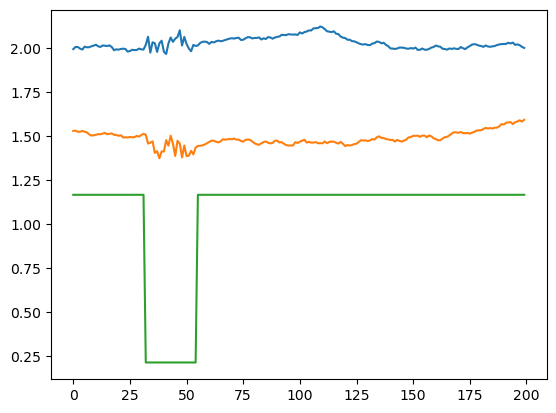

In [8]:
plt.plot(paper_traj[1]/70)
plt.plot(paper_traj[0]/70)

plt.plot(paper_label[0])

Since the trajectory is shorter thatn 256, which is what the old network used let us repeat it twice

In [9]:
shift = paper_traj[:, -1] - paper_traj[:, 0]

In [10]:
shift

array([4.43489915, 0.48475306])

In [11]:
arr_shifted = paper_traj + shift[:, np.newaxis]

In [12]:
tr=np.concatenate((paper_traj,arr_shifted),axis=1)
label = np.concatenate((paper_label[0],paper_label[0]))

In [13]:
np.shape(tr)

(2, 400)

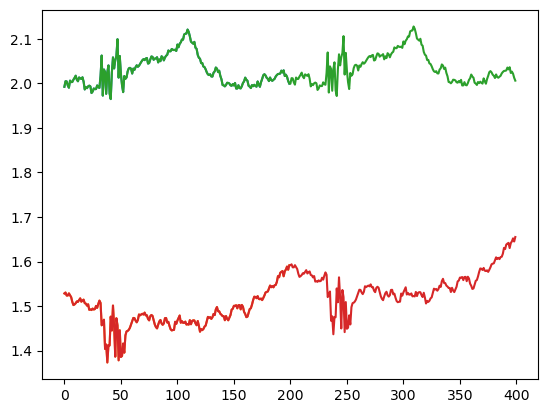

In [14]:
plt.plot(paper_traj[1]/70)
plt.plot(paper_traj[0]/70)
plt.plot(tr[1]/70)
plt.plot(tr[0]/70)
# plt.plot(paper_label[1])

Let us analyse how a sliding window of length 256 would perform on the example trajectory. We start using the x component only.

n initial= 0 gap= 0
warning!! Overlapping trajectories. gap= 0 trajectory length= 256 final_point= 256 data length 256
5/5 [==============================] - 0s 21ms/step


/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/4085194406.py:35: RuntimeWarning: Mean of empty slice
  lamx=np.nanmean(pr_alph,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/4085194406.py:99: RuntimeWarning: Mean of empty slice
  lamsd32=np.nanmean(msd_alph32,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/4085194406.py:100: RuntimeWarning: Mean of empty slice
  lamsd64=np.nanmean(msd_alph64,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/4085194406.py:101: RuntimeWarning: Mean of empty slice
  lamsd256=np.nanmean(msd_alph256,axis=0)


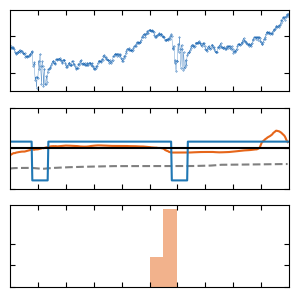

In [27]:

sk=1
timess=np.array([1023])
#fig, (ax0, ax1, ax2) = plt.subplots(3,figsize=(10,10),sharex=True)
fig, (ax0, ax1, ax2) = plt.subplots(3,figsize=(9/2.5,9/2.5),sharex=True)
for jj in range(1):
    
    traj_len=256
    belplot=tr[0]
    times_c=np.empty((0,traj_len))
    seg=np.empty((0,traj_len))
    lab_c=np.empty((0,5))
    for j in range(0,len(belplot)-traj_len):

        times=np.arange(j,j+traj_len)
        seg=np.append(seg,[belplot[times]],axis=0)
        times_c=np.append(times_c,[times],axis=0)
        lab_c=np.append(lab_c,[np.array([0,0,0,0,0])],axis=0)
    data_c,label_c_norm,traj_c,times_c_norm=data_split(seg,times_c,labels=lab_c,\
                                                       start_row=0,num_row=len(belplot)-traj_len,\
                                                       traj_len=traj_len,n_in=0,n_samples=1,p_p=1,\
                                                       hmin=0.25,hmax=0.75,limith=False,normalization=True)
    pr_c_50_y=model_change256.predict(data_c)


    fir2=(int(np.round(traj_len*my_atan(pr_c_50_y[0,3].flatten(),pr_c_50_y[0,4].flatten())/(2*np.pi))))
    pr_alph=np.concatenate((pr_c_50_y[0,0]*np.ones(fir2),pr_c_50_y[0,1]*np.ones(traj_len-fir2),np.full(len(pr_c_50_y),np.nan)))

    for i in range(1,len(pr_c_50_y)):
        bef=np.full(i,np.nan)
        aft=np.full(len(pr_c_50_y)-i,np.nan)
        fir2=(int(np.round(traj_len*my_atan(pr_c_50_y[i,3].flatten(),pr_c_50_y[i,4].flatten())/(2*np.pi))))
        pr_alph=(np.concatenate((pr_alph,bef,pr_c_50_y[i,0]*np.ones(fir2),pr_c_50_y[i,1]*np.ones(traj_len-fir2),aft)))
        #print(fir2)
    pr_alph=pr_alph.reshape(-1,traj_len+len(pr_c_50_y))    
    lamx=np.nanmean(pr_alph,axis=0)
    
    
    traj_len256=256
    times_c256=np.empty((0,traj_len256))
    seg=np.empty((0,traj_len256))
    lab_c256=np.empty((0,5))
    ltot=len(belplot)-traj_len256
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len256)

        if(j==0):
            msd_alph256=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len256),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph256=(np.concatenate((msd_alph256,bef,h_exp(belplot[times],5)*np.ones(traj_len256),aft)))
    msd_alph256=msd_alph256.reshape(-1,traj_len256+ltot)
    #print(pr_c256)
    traj_len64=64
    times_c64=np.empty((0,traj_len64))
    seg=np.empty((0,traj_len64))
    lab_c64=np.empty((0,5))
    ltot=len(belplot)-traj_len64
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len64)

        if(j==0):
            msd_alph64=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len64),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph64=(np.concatenate((msd_alph64,bef,h_exp(belplot[times],5)*np.ones(traj_len64),aft)))
    msd_alph64=msd_alph64.reshape(-1,traj_len64+ltot) 
    #print(pr_c64)    
    

    traj_len32=32
    times_c32=np.empty((0,traj_len32))
    seg=np.empty((0,traj_len32))
    lab_c32=np.empty((0,5))
    ltot=len(belplot)-traj_len32
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len32)

        if(j==0):
            msd_alph32=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len32),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph32=(np.concatenate((msd_alph32,bef,h_exp(belplot[times],5)*np.ones(traj_len32),aft)))
    msd_alph32=msd_alph32.reshape(-1,traj_len32+ltot)
    #print(pr_c32)    

    
    lamsd32=np.nanmean(msd_alph32,axis=0)
    lamsd64=np.nanmean(msd_alph64,axis=0)
    lamsd256=np.nanmean(msd_alph256,axis=0)
    
    #ax0.plot(super1_s[::sk,1],color="#e6661a")
    ax0.plot(np.arange(len(belplot))+jj/sk,belplot,"-o",markersize=0.3, linewidth=0.2, color=((jj%3)/3,((jj+1)%3)/3,((jj+2)%3)/3))#,color="blue")
    ax0.set_xlim(0,len(belplot))
    # ax0.plot((exp_data_ch[:,1][:timess[0]]),color=my_col(test_targets[h]),label="$\\alpha$=%.2f" %(2*test_targets[h]))
    # ax0.plot(np.arange(timess[0],timess[1]),(exp_data_ch[:,1][timess[0]:timess[1]]),color=my_col(test_targets[l]),label="$\\alpha$=%.2f" %(2*test_targets[l]))
    #ax0.plot((exp_data_ch[:,1][:timess[0]]),color=my_col((1*0.75/2+0.75/2)),label="$\\alpha$=%.2f" %(2*(1*0.75/2+0.75/2)))
    #ax0.plot(np.arange(timess[0],timess[1]),(exp_data_ch[:,1][timess[0]:timess[1]]),color=my_col((0*0.75/2+0.75/2)),label="$\\alpha$=%.2f" %(2*((0*0.75/2+0.75/2))))
    #ax0.set_ylim(-0.00003,0)
    #ax0.tick_params(labelsize=8)
    ax0.set_xticks(np.arange(40,len(belplot),40))
    #ax0.set_xticklabels([0,'',500,'',1000,'',1500,'',2000])


    
    # ax0.set_xticklabels([''])
    ax0.set_yticklabels([])



    
    #ax0.set_yticks([-0.00003,-0.00001,0])
    #ax0.set_ylabel("position",fontsize=14)
    # for i in range(1,39):
    #     if(i%2==0):
    #         ind=l
    #     else:
    #         ind=h
    #     ax0.plot(np.arange(timess[i],timess[i+1]),exp_data_ch[:,1][timess[i]:timess[i+1]],color=my_col(ind*0.5+0.75/2))

    # ax0.plot(np.arange(timess[i+1],len(exp_data_ch[:,1])),exp_data_ch[:,1][timess[i+1]:len(exp_data_ch[:,1])],color=my_col(ind*0.5+0.75/2))

    #ax0.plot(np.arange(2200,2456),140*np.ones(256),color="k")
    #ax0.plot(exp_data_ch[:,1]-test_many_tr[l,:timess[7]])
    #ax0.plot(exp_data_ch[:,1]-test_many_tr[h,:timess[7]])
    #ax0.plot(exp_data_ch[:,1]2)
    #ax0.scatter(timess[:7], exp_data_ch[:,1][timess[:7]])
    #ax0.legend(fontsize=8)
    #ax0.set_xlim(0,len(exp_data_ch[:,1]))
    #fig.tight_layout() 
    ax0.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    #ax0.legend()
    #fig, ax1 =plt.subplots(figsize=(9/2.5,3/2.5))
    # ax1.scatter(np.arange(0,traj_len),2*pr_c_exp_NOC[:traj_len,0],0.5,color="blue",marker='v',label="$\\hat{\\alpha}_1$")
    # ax1.scatter(np.arange(len(exp_data_ch[:,1])-traj_len,len(exp_data_ch[:,1])),2*pr_c_exp_NOC[-traj_len:,1],color="blue",marker='^',label="$\\hat{\\alpha}_2$")
    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_NOC[traj_len:,0]+pr_c_exp_NOC[:-traj_len,1]),color="blue",label="$\\hat{\\alpha}_2$")

    # ax1.scatter(np.arange(len(exp_data_ch[:,1])-traj_len,len(exp_data_ch[:,1])),2*pr_c_exp[-traj_len:,1],color="#e6661a",marker='^',label="$\\hat{\\alpha}_2$")
    # ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp[traj_len:,0]+pr_c_exp[:-traj_len,1]),color="#e6661a",label="$\\hat{\\alpha}_2$")

    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_a1a2[traj_len:,0]+pr_c_exp_a1a2[:-traj_len,1]),color="green",label="$\\hat{\\alpha}_2$")
    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_a1a2[traj_len:,0])*2,color="red",label="$\\hat{\\alpha}_2$")
#     ax1.scatter(np.arange(0,traj_len)+jj/sk,2*(pr_c_50_y[:traj_len,0]),0.5,color="#e6661a")#,color=((jj%3)/3,((jj+1)%3)/3,((jj+2)%3)/3))#,color="#e6661a",label="$\\hat{\\alpha}_2$")

#     ax1.scatter(np.arange(traj_len+jj/sk,len(belplot)-traj_len),(pr_c_50_y[traj_len:,0]+pr_c_50_y[:-traj_len,1]),0.5,color="#e6661a")#,color="#e6661a",label="$\\hat{\\alpha}_2$")

#     ax1.scatter(np.arange(len(belplot)-traj_len,len(belplot))+jj/sk,2*(pr_c_50_y[-traj_len:,1]),0.5,color="#e6661a")#,color="#e6661a",label="$\\hat{\\alpha}_2$")
    ax1.plot(np.arange(0,len(belplot))+jj/sk,2*lamx,color="#e6661a")

    ax1.set_xlim(0,len(belplot))
    ax1.set_ylim(0.,2)
    ax1.set_yticklabels([])
    #ax1.plot(2*lamsd64,'--',color="gray")
    ax1.plot(2*lamsd256,'--',color="gray")
    ax1.plot(label)
    ax1.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    ax1.axhline(y=1,color='k')

    #ax1.plot(a1plt[256:],color='g',label='$\\alpha_2$')
    #ax1.legend(fontsize=8)
    #ax2.legend(fontsize=8)
        #
        # for tt in timess:
    #     if tt>255:
    #         x=np.arange(tt-256,tt)
    #         ax1.plot(x,1.5*np.ones(len(x)),"b",linewidth=1.0,alpha=0.5)#,label="$t-t_c$")
    #     else:
    #         x=np.arange(0,tt)
    # #x=np.arange(2378-256,2378)
    #         ax1.plot(x,1.5*np.ones(len(x)),"b",linewidth=1.0,alpha=0.5)#,label="$t-t_c$")
    #ax1.scatter(timess-256,0.75*np.ones(len(timess)),color='k')
    #ax1.scatter(timess,0.75*np.ones(len(timess)),color='r')

    #ax1.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    ax2.axvline(x=timess[0]/sk,color='r',linewidth=1)
    ax1.axvline(x=timess[0]/sk,color='r',linewidth=1)
    ax0.axvline(x=timess[0]/sk,color='r',linewidth=1)

    kondoy=np.where((pr_c_50_y[:,4]<0)&(np.abs(pr_c_50_y[:,2])>0.125))[0] 
    ax2.hist((kondoy+jj/sk+256*my_atan(pr_c_50_y[kondoy,3].flatten(),pr_c_50_y[kondoy,4].flatten())/(2*np.pi)),\
             bins=np.arange(0,len(belplot),20),density=True,alpha=0.5,color="#e6661a")

    ax2.set_xlim(0,len(belplot))
    ax2.set_xticks(np.arange(40,len(belplot),40))
    et=np.array(np.arange(40,len(belplot),40)*0.15)
    ax2.set_xticklabels([])    
    ax2.set_yticks([0,0.01,0.02])
    #in order to have frequency and not density multiply by bin length
    ax2.set_yticklabels([]*20)
    ax2.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)

fig.savefig('fig1_comparePREx.pdf',bbox_inches='tight')

And now the y component

n initial= 0 gap= 0
warning!! Overlapping trajectories. gap= 0 trajectory length= 256 final_point= 256 data length 256
5/5 [==============================] - 0s 22ms/step


/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/1974620920.py:35: RuntimeWarning: Mean of empty slice
  lamy=np.nanmean(pr_alph,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/1974620920.py:99: RuntimeWarning: Mean of empty slice
  lamsd32=np.nanmean(msd_alph32,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/1974620920.py:100: RuntimeWarning: Mean of empty slice
  lamsd64=np.nanmean(msd_alph64,axis=0)
/var/folders/q1/rhj_j2hj7t5121p5rh10b1p00000gq/T/ipykernel_11027/1974620920.py:101: RuntimeWarning: Mean of empty slice
  lamsd256=np.nanmean(msd_alph256,axis=0)


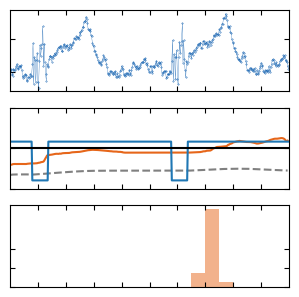

In [28]:

sk=1
timess=np.array([1023])
#fig, (ax0, ax1, ax2) = plt.subplots(3,figsize=(10,10),sharex=True)
fig, (ax0, ax1, ax2) = plt.subplots(3,figsize=(9/2.5,9/2.5),sharex=True)
for jj in range(1):
    
    traj_len=256
    belplot=tr[1]
    times_c=np.empty((0,traj_len))
    seg=np.empty((0,traj_len))
    lab_c=np.empty((0,5))
    for j in range(0,len(belplot)-traj_len):

        times=np.arange(j,j+traj_len)
        seg=np.append(seg,[belplot[times]],axis=0)
        times_c=np.append(times_c,[times],axis=0)
        lab_c=np.append(lab_c,[np.array([0,0,0,0,0])],axis=0)
    data_c,label_c_norm,traj_c,times_c_norm=data_split(seg,times_c,labels=lab_c,\
                                                       start_row=0,num_row=len(belplot)-traj_len,\
                                                       traj_len=traj_len,n_in=0,n_samples=1,p_p=1,\
                                                       hmin=0.25,hmax=0.75,limith=False,normalization=True)
    pr_c_50_y=model_change256.predict(data_c)


    fir2=(int(np.round(traj_len*my_atan(pr_c_50_y[0,3].flatten(),pr_c_50_y[0,4].flatten())/(2*np.pi))))
    pr_alph=np.concatenate((pr_c_50_y[0,0]*np.ones(fir2),pr_c_50_y[0,1]*np.ones(traj_len-fir2),np.full(len(pr_c_50_y),np.nan)))

    for i in range(1,len(pr_c_50_y)):
        bef=np.full(i,np.nan)
        aft=np.full(len(pr_c_50_y)-i,np.nan)
        fir2=(int(np.round(traj_len*my_atan(pr_c_50_y[i,3].flatten(),pr_c_50_y[i,4].flatten())/(2*np.pi))))
        pr_alph=(np.concatenate((pr_alph,bef,pr_c_50_y[i,0]*np.ones(fir2),pr_c_50_y[i,1]*np.ones(traj_len-fir2),aft)))
        #print(fir2)
    pr_alph=pr_alph.reshape(-1,traj_len+len(pr_c_50_y))    
    lamy=np.nanmean(pr_alph,axis=0)
    
    
    traj_len256=256
    times_c256=np.empty((0,traj_len256))
    seg=np.empty((0,traj_len256))
    lab_c256=np.empty((0,5))
    ltot=len(belplot)-traj_len256
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len256)

        if(j==0):
            msd_alph256=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len256),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph256=(np.concatenate((msd_alph256,bef,h_exp(belplot[times],5)*np.ones(traj_len256),aft)))
    msd_alph256=msd_alph256.reshape(-1,traj_len256+ltot)
    #print(pr_c256)
    traj_len64=64
    times_c64=np.empty((0,traj_len64))
    seg=np.empty((0,traj_len64))
    lab_c64=np.empty((0,5))
    ltot=len(belplot)-traj_len64
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len64)

        if(j==0):
            msd_alph64=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len64),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph64=(np.concatenate((msd_alph64,bef,h_exp(belplot[times],5)*np.ones(traj_len64),aft)))
    msd_alph64=msd_alph64.reshape(-1,traj_len64+ltot) 
    #print(pr_c64)    
    

    traj_len32=32
    times_c32=np.empty((0,traj_len32))
    seg=np.empty((0,traj_len32))
    lab_c32=np.empty((0,5))
    ltot=len(belplot)-traj_len32
    for j in range(0,ltot):

        times=np.arange(j,j+traj_len32)

        if(j==0):
            msd_alph32=np.concatenate((h_exp(belplot[times],5)*np.ones(traj_len32),np.full(ltot,np.nan)))
        else:

            bef=np.full(j,np.nan)
            aft=np.full(ltot-j,np.nan)
            #fir2=(int(np.round(traj_len*my_atan(pr_c[i,3].flatten(),pr_c[i,4].flatten())/(2*np.pi))))
            msd_alph32=(np.concatenate((msd_alph32,bef,h_exp(belplot[times],5)*np.ones(traj_len32),aft)))
    msd_alph32=msd_alph32.reshape(-1,traj_len32+ltot)
    #print(pr_c32)    

    
    lamsd32=np.nanmean(msd_alph32,axis=0)
    lamsd64=np.nanmean(msd_alph64,axis=0)
    lamsd256=np.nanmean(msd_alph256,axis=0)
    
    #ax0.plot(super1_s[::sk,1],color="#e6661a")
    ax0.plot(np.arange(len(belplot))+jj/sk,belplot,"-o",markersize=0.3, linewidth=0.2, color=((jj%3)/3,((jj+1)%3)/3,((jj+2)%3)/3))#,color="blue")
    ax0.set_xlim(0,len(belplot))
    # ax0.plot((exp_data_ch[:,1][:timess[0]]),color=my_col(test_targets[h]),label="$\\alpha$=%.2f" %(2*test_targets[h]))
    # ax0.plot(np.arange(timess[0],timess[1]),(exp_data_ch[:,1][timess[0]:timess[1]]),color=my_col(test_targets[l]),label="$\\alpha$=%.2f" %(2*test_targets[l]))
    #ax0.plot((exp_data_ch[:,1][:timess[0]]),color=my_col((1*0.75/2+0.75/2)),label="$\\alpha$=%.2f" %(2*(1*0.75/2+0.75/2)))
    #ax0.plot(np.arange(timess[0],timess[1]),(exp_data_ch[:,1][timess[0]:timess[1]]),color=my_col((0*0.75/2+0.75/2)),label="$\\alpha$=%.2f" %(2*((0*0.75/2+0.75/2))))
    #ax0.set_ylim(-0.00003,0)
    #ax0.tick_params(labelsize=8)
    ax0.set_xticks(np.arange(40,len(belplot),40))
    #ax0.set_xticklabels([0,'',500,'',1000,'',1500,'',2000])


    
    # ax0.set_xticklabels([''])
    ax0.set_yticklabels([])



    
    #ax0.set_yticks([-0.00003,-0.00001,0])
    #ax0.set_ylabel("position",fontsize=14)
    # for i in range(1,39):
    #     if(i%2==0):
    #         ind=l
    #     else:
    #         ind=h
    #     ax0.plot(np.arange(timess[i],timess[i+1]),exp_data_ch[:,1][timess[i]:timess[i+1]],color=my_col(ind*0.5+0.75/2))

    # ax0.plot(np.arange(timess[i+1],len(exp_data_ch[:,1])),exp_data_ch[:,1][timess[i+1]:len(exp_data_ch[:,1])],color=my_col(ind*0.5+0.75/2))

    #ax0.plot(np.arange(2200,2456),140*np.ones(256),color="k")
    #ax0.plot(exp_data_ch[:,1]-test_many_tr[l,:timess[7]])
    #ax0.plot(exp_data_ch[:,1]-test_many_tr[h,:timess[7]])
    #ax0.plot(exp_data_ch[:,1]2)
    #ax0.scatter(timess[:7], exp_data_ch[:,1][timess[:7]])
    #ax0.legend(fontsize=8)
    #ax0.set_xlim(0,len(exp_data_ch[:,1]))
    #fig.tight_layout() 
    ax0.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    #ax0.legend()
    #fig, ax1 =plt.subplots(figsize=(9/2.5,3/2.5))
    # ax1.scatter(np.arange(0,traj_len),2*pr_c_exp_NOC[:traj_len,0],0.5,color="blue",marker='v',label="$\\hat{\\alpha}_1$")
    # ax1.scatter(np.arange(len(exp_data_ch[:,1])-traj_len,len(exp_data_ch[:,1])),2*pr_c_exp_NOC[-traj_len:,1],color="blue",marker='^',label="$\\hat{\\alpha}_2$")
    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_NOC[traj_len:,0]+pr_c_exp_NOC[:-traj_len,1]),color="blue",label="$\\hat{\\alpha}_2$")

    # ax1.scatter(np.arange(len(exp_data_ch[:,1])-traj_len,len(exp_data_ch[:,1])),2*pr_c_exp[-traj_len:,1],color="#e6661a",marker='^',label="$\\hat{\\alpha}_2$")
    # ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp[traj_len:,0]+pr_c_exp[:-traj_len,1]),color="#e6661a",label="$\\hat{\\alpha}_2$")

    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_a1a2[traj_len:,0]+pr_c_exp_a1a2[:-traj_len,1]),color="green",label="$\\hat{\\alpha}_2$")
    #ax1.plot(np.arange(traj_len,len(exp_data_ch[:,1])-traj_len),(pr_c_exp_a1a2[traj_len:,0])*2,color="red",label="$\\hat{\\alpha}_2$")
#     ax1.scatter(np.arange(0,traj_len)+jj/sk,2*(pr_c_50_y[:traj_len,0]),0.5,color="#e6661a")#,color=((jj%3)/3,((jj+1)%3)/3,((jj+2)%3)/3))#,color="#e6661a",label="$\\hat{\\alpha}_2$")

#     ax1.scatter(np.arange(traj_len+jj/sk,len(belplot)-traj_len),(pr_c_50_y[traj_len:,0]+pr_c_50_y[:-traj_len,1]),0.5,color="#e6661a")#,color="#e6661a",label="$\\hat{\\alpha}_2$")

#     ax1.scatter(np.arange(len(belplot)-traj_len,len(belplot))+jj/sk,2*(pr_c_50_y[-traj_len:,1]),0.5,color="#e6661a")#,color="#e6661a",label="$\\hat{\\alpha}_2$")
    ax1.plot(np.arange(0,len(belplot))+jj/sk,2*lamy,color="#e6661a")

    ax1.set_xlim(0,len(belplot))
    ax1.set_ylim(0.,2)
    ax1.set_yticklabels([])
    #ax1.plot(2*lamsd64,'--',color="gray")
    ax1.plot(2*lamsd256,'--',color="gray")
    ax1.plot(label)
    ax1.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    ax1.axhline(y=1,color='k')

    #ax1.plot(a1plt[256:],color='g',label='$\\alpha_2$')
    #ax1.legend(fontsize=8)
    #ax2.legend(fontsize=8)
        #
        # for tt in timess:
    #     if tt>255:
    #         x=np.arange(tt-256,tt)
    #         ax1.plot(x,1.5*np.ones(len(x)),"b",linewidth=1.0,alpha=0.5)#,label="$t-t_c$")
    #     else:
    #         x=np.arange(0,tt)
    # #x=np.arange(2378-256,2378)
    #         ax1.plot(x,1.5*np.ones(len(x)),"b",linewidth=1.0,alpha=0.5)#,label="$t-t_c$")
    #ax1.scatter(timess-256,0.75*np.ones(len(timess)),color='k')
    #ax1.scatter(timess,0.75*np.ones(len(timess)),color='r')

    #ax1.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)
    ax2.axvline(x=timess[0]/sk,color='r',linewidth=1)
    ax1.axvline(x=timess[0]/sk,color='r',linewidth=1)
    ax0.axvline(x=timess[0]/sk,color='r',linewidth=1)

    kondoy=np.where((pr_c_50_y[:,4]<0)&(np.abs(pr_c_50_y[:,2])>0.125))[0] 
    ax2.hist((kondoy+jj/sk+256*my_atan(pr_c_50_y[kondoy,3].flatten(),pr_c_50_y[kondoy,4].flatten())/(2*np.pi)),\
             bins=np.arange(0,len(belplot),20),density=True,alpha=0.5,color="#e6661a")

    ax2.set_xlim(0,len(belplot))
    ax2.set_xticks(np.arange(40,len(belplot),40))
    et=np.array(np.arange(40,len(belplot),40)*0.15)
    ax2.set_xticklabels([])    
    ax2.set_yticks([0,0.01,0.02])
    #in order to have frequency and not density multiply by bin length
    ax2.set_yticklabels([]*20)
    ax2.tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True, labelsize=8)

fig.savefig('fig1_comparePREy.pdf',bbox_inches='tight')

(0.0, 2.0)

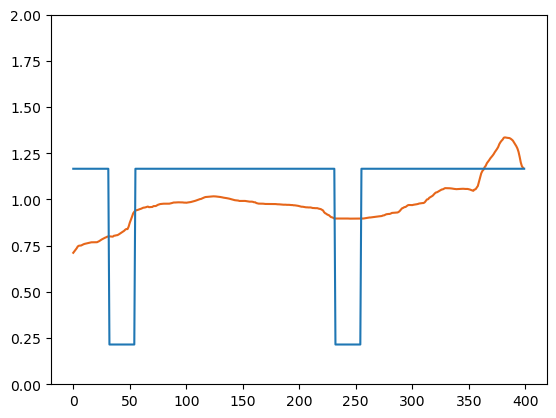

In [29]:
plt.plot(np.arange(0,len(belplot))+jj/sk,2*(lamy+lamx)/2,color="#e6661a")
plt.plot(label)
plt.ylim(0,2)